In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import io

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving TrafficVolume_TestData.csv to TrafficVolume_TestData (1).csv
Saving TrafficVolume_TrainingData.csv to TrafficVolume_TrainingData (1).csv


In [ ]:
# Import the training set
dataset_train = pd.read_csv(io.BytesIO(uploaded['TrafficVolume_TrainingData.csv']))
training_set = dataset_train.iloc[:288, 1:2].values # Use time interval and traffic volume columns
print(training_set)

In [ ]:
# Feature scaling
# from sklearn.preprocessing import Normalizer
# training_set_normalized = Normalizer().fit(training_set)
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0,1))
training_set_scaled= sc.fit_transform(training_set)
preparedTrainingSet = training_set_scaled

In [ ]:
# Creating a data structure with 24 timesteps and 1 output
# Given the last 24 hour intervals of traffic, what will the traffic volume be in the next hour?
x_train = []
y_train = []
for i in range(24,288): # 24 becuase we want to always have 24 hours of data available to us from our sheet.
                        # 290 because our training data stops at row 289 and we want to get row 289.
  x_train.append(preparedTrainingSet[i-24:i, 0]) # i - 24 because we want to last 24 hours of data
                                                 # Zero refers to the 'time' column from our training_set_scaled
  y_train.append(preparedTrainingSet[i,0])       # This pulls the y value for the current hour
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshaping
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1)) # make x_train a 24 x 290 matrix thingy with one layer

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [ ]:
# Initialize the RNN
regressor = Sequential()

In [ ]:
# Adding the first LSTM Layer and some Dropout regularization
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (x_train.shape[1], 1)))
  # Units = 20 is the dimensionality of the output space. What is going into the next layer
regressor.add(Dropout(0.2))
  # Don't train 20% of our neurons so we don't train for specific numbers only. The neurons will turn on for the next cycle
  

In [ ]:
# Adding a second LSTM Layer and some Dropout regularization
regressor.add(LSTM(units = 50, return_sequences = True)) # Doesn't need to know what the shape is thanks to the above cell
regressor.add(Dropout(0.2))

In [ ]:
# Adding a third LSTM Layer and some Dropout regularization
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

In [ ]:
# Adding a fourth LSTM Layer and some Dropout regularization
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

In [ ]:
# Adding the output layer
regressor.add(Dense(units = 1)) # Dense says force everything to give us one output in the very end.

In [ ]:
# Compile the RNN
regressor.compile(optimizer='adam', loss = 'mean_squared_error') # Adam is a big data optimizer
                                                                 # mean_squared_error says use the mean squared number to 
                                                                 # say how off our guess was.

In [ ]:
# Fitting the RNN to the training set
regressor.fit(x_train, y_train, epochs=100, batch_size = 32) # epochs = how many times we will go over our dataset.
                                                            # batch_size = 32 says get small batch sizes so you don't screw your RAM

Epoch 1/100
9/9 [==============================] - 7s 46ms/step - loss: 0.3092
Epoch 2/100
9/9 [==============================] - 0s 49ms/step - loss: 0.1621
Epoch 3/100
9/9 [==============================] - 0s 45ms/step - loss: 0.1380
Epoch 4/100
9/9 [==============================] - 0s 53ms/step - loss: 0.1237
Epoch 5/100
9/9 [==============================] - 0s 48ms/step - loss: 0.1172
Epoch 6/100
9/9 [==============================] - 0s 52ms/step - loss: 0.1148
Epoch 7/100
9/9 [==============================] - 0s 50ms/step - loss: 0.1156
Epoch 8/100
9/9 [==============================] - 0s 50ms/step - loss: 0.1127
Epoch 9/100
9/9 [==============================] - 0s 52ms/step - loss: 0.1005
Epoch 10/100
9/9 [==============================] - 0s 52ms/step - loss: 0.0938
Epoch 11/100
9/9 [==============================] - 0s 49ms/step - loss: 0.0954
Epoch 12/100
9/9 [==============================] - 0s 51ms/step - loss: 0.1008
Epoch 13/100
9/9 [==============================]

In [ ]:
# Part 3 - Making the predictions and visualizing the results

# Getting the real traffic volume of 2019
dataset_test = pd.read_csv('TrafficVolume_TestData.csv')
real_traffic_volume = dataset_test.iloc[:288, 1:2].values

In [ ]:
# Getting the predicted traffic volume of 2019
dataset_total = pd.concat((dataset_train['TrafficVolume'], dataset_test['TrafficVolume']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 24:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(24, 288):
  X_test.append(inputs[i-24:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_traffic_volume = regressor.predict(X_test)
print(type(predicted_traffic_volume))
print(predicted_traffic_volume.ndim)
print(predicted_traffic_volume)

npredictions, nx, ny = predicted_traffic_volume.shape
d2_predicted_dataset = predicted_traffic_volume.reshape((npredictions,nx*ny))

predicted_traffic_volume = sc.inverse_transform(d2_predicted_dataset)

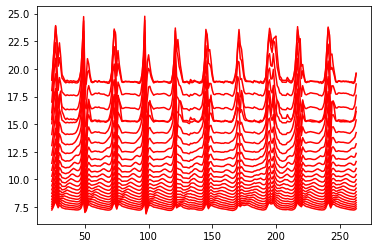

In [ ]:
# Visualizing the results
plt.plot(predicted_traffic_volume, color = 'red', label = "Predicted Traffic Volume")
